<a href="https://colab.research.google.com/github/shuvayan/Plant-disease-detection-using-CNN/blob/main/LeafGuard_Modern_CNN_Architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries

In [2]:
import cv2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

# import data handling tools
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam, Adamax
from keras.metrics import categorical_crossentropy
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras import regularizers
from keras.applications import EfficientNetB7,MobileNetV2

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


Let's use the Plants Village data and create datasets.

In [4]:
# defining path names for futur use
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/Augmented_PlantVillage'

train_path = data_dir + '/train'
validation_path = data_dir + '/valid'
test_path = data_dir + '/test'

Mounted at /content/drive


In [5]:
from sklearn.utils.class_weight import compute_class_weight

In [6]:
# Preprocessing function


def preprocess_image(image):
    # Resize the image
    image = cv2.resize(image, (256, 256))

    # Convert to Lab color space
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # Split into L, A, B channels
    l_channel, a_channel, b_channel = cv2.split(lab_image)

    # Convert L channel to uint8 if needed
    if l_channel.dtype != np.uint8:
        l_channel = (l_channel * 255 / l_channel.max()).astype(np.uint8)

    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_channel = clahe.apply(l_channel)

    # Resize the L channel back to match A and B channels, if necessary
    l_channel = cv2.resize(l_channel, (a_channel.shape[1], a_channel.shape[0]))

    # Ensure all channels have the same type
    l_channel = l_channel.astype(a_channel.dtype)
    b_channel = b_channel.astype(a_channel.dtype)

    # Merge channels back
    lab_image = cv2.merge((l_channel, a_channel, b_channel))

    # Convert back to RGB
    image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)

    # Apply gamma correction
    gamma = 1.2
    image = np.power(image / 255.0, gamma)

    # Normalize pixel values to [-1, 1]
    image = image * 2 - 1
    return image



In [7]:


# Data Generators
size = 256
batch_size = 128
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    preprocessing_function=preprocess_image,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(size, size),
    batch_size=batch_size,
    subset="training",
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(size, size),
    batch_size=batch_size,
    subset="validation",
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


Found 63391 images belonging to 38 classes.
Found 7025 images belonging to 38 classes.


In [ ]:
sample_weights = np.array([class_weights[cls] for cls in train_generator.classes])

def add_sample_weights_with_values(generator, sample_weights):
    for i, (inputs, labels) in enumerate(generator):
        batch_indices = generator.index_array[i * generator.batch_size: (i + 1) * generator.batch_size]
        yield (inputs, labels, sample_weights[batch_indices])

train_generator_with_weights = add_sample_weights_with_values(train_generator, sample_weights)
validation_generator_with_weights = add_sample_weights_with_values(validation_generator, sample_weights)

In [8]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ReLU, BatchNormalization, GlobalAveragePooling2D
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

def create_cnn_with_mobilenetv2(K):
    # Load MobileNetV2 as the base model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    # Freeze the layers of MobileNetV2
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top of MobileNetV2
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())  # Replace Flatten with GlobalAveragePooling2D for better performance
    model.add(Dropout(0.4))
    model.add(Dense(1024))
    model.add(ReLU())
    model.add(Dropout(0.4))
    model.add(Dense(K))  # Output layer for classification

    return model


In [9]:
K = 38  # Number of classes
model = create_cnn_with_mobilenetv2(K)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 38)                  │          38,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,608,678 (13.77 MB)

 Trainable params: 1,350,694 (5.15 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train the model
history = model.fit(
    train_generator
    ,validation_data=validation_generator
    #,batch_size = 128,
    #,validation_batch_size = 128
    ,epochs=10
    ,class_weight=class_weights
)

Epoch 1/10
  4/496 ━━━━━━━━━━━━━━━━━━━━ 4:41:52 34s/step - accuracy: 0.0138 - loss: 8.1517

In [ ]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    Epochs = [i+1 for i in range(len(tr_acc))]

    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

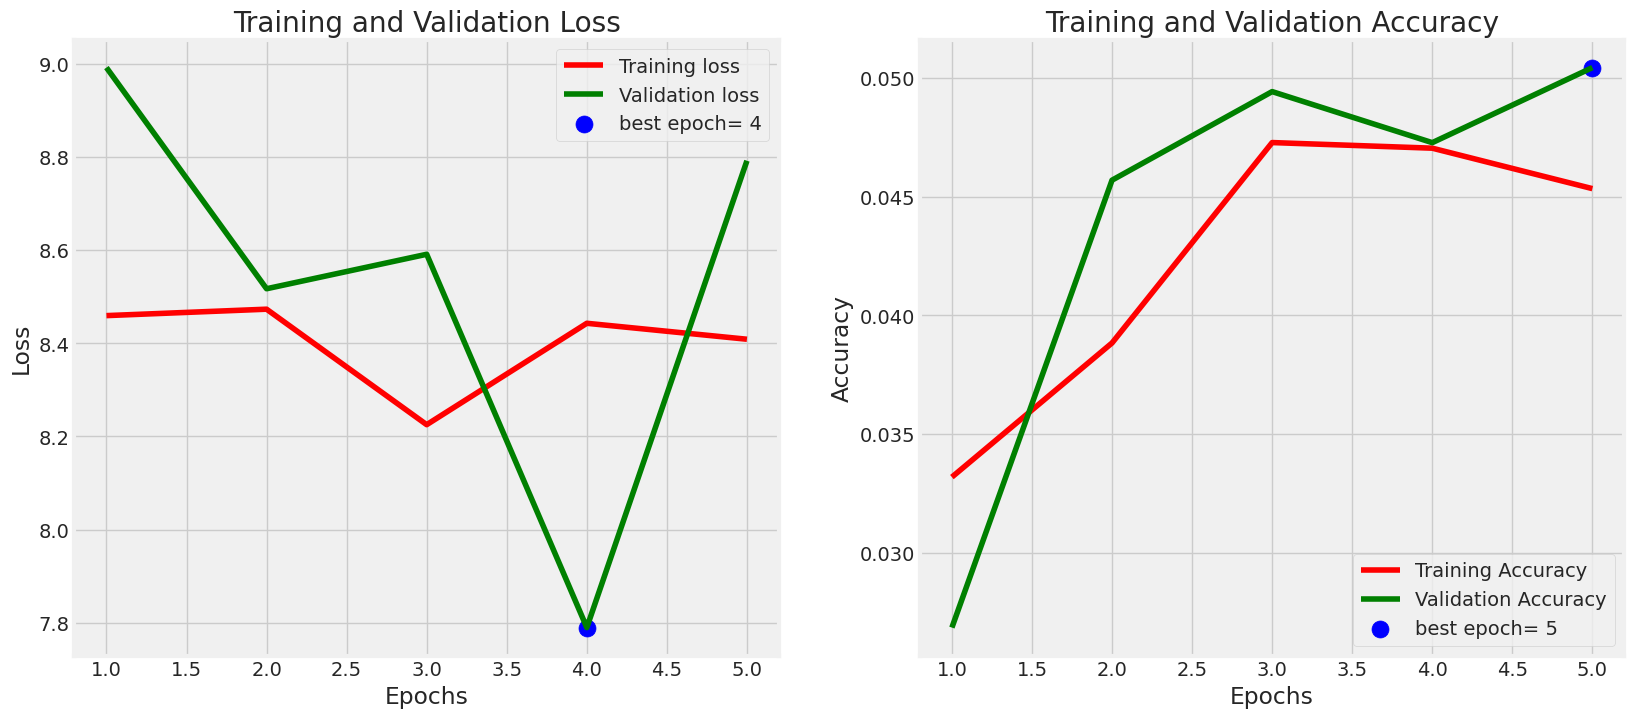

In [ ]:
plot_training(hist)

In [ ]:
preds = model.predict_generator(valid_generator)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[33 33  2 ...  2  2  2]


In [ ]:
label_mapping = valid_generator.class_indices
label_mapping = {v: k for k, v in label_mapping.items()}  # Reverse mapping

In [ ]:
predicted_classes = [label_mapping[label] for label in y_pred]
print(predicted_classes)  # E.g., ['Tomato Leaf Mold', 'Apple Black Rot', ...]

['Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Apple___Cedar_apple_rust', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Leaf_Mold', 'Potato___healthy', 'Apple___Cedar_apple_rust', 'Tomato___Early_blight', 'Apple___Cedar_apple_rust', 'Tomato___Septoria_leaf_spot', 'Tomato___Early_blight', 'Apple___Cedar_apple_rust', 'Tomato___Early_blight', 'Strawberry___healthy', 'Tomato___Early_blight', 'Cherry_(including_sour)___Powdery_mildew', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Apple___Cedar_apple_rust', 'Apple___Cedar_apple_rust', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Apple___Cedar_apple_rust', 'Apple___Cedar_apple_rust', 'Tomato___Early_blight', 'Tomato___healthy', 'Apple___Cedar_apple_rust', 'Tomato___Early_blight', 'Apple___Cedar_apple_rust', 'Squash___Powdery_mildew', 'Apple___Cedar_apple_rust', 'Apple___Cedar_apple_rust', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Apple___Cedar_apple_rust', 'Toma

In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        color_mode="rgb",
        shuffle = "false",
        class_mode='categorical')

filenames = test_generator.filenames
nb_samples = len(filenames)

Found 33 images belonging to 8 classes.


In [ ]:
preds = model.predict_generator(test_generator)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[ 2 29 32 29  2 37  2  2 29 37  2  2  2 32  2  2  2  2 22  2  2  2 37  2
  2  2  2 37  2 20 29  2  2]


In [ ]:
label_mapping = valid_generator.class_indices
label_mapping = {v: k for k, v in label_mapping.items()}  # Reverse mapping

predicted_classes = [label_mapping[label] for label in y_pred]
print(predicted_classes)  # E.g., ['Tomato Leaf Mold', 'Apple Black Rot', ...]

['Apple___Cedar_apple_rust', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___Early_blight', 'Apple___Cedar_apple_rust', 'Tomato___healthy', 'Apple___Cedar_apple_rust', 'Apple___Cedar_apple_rust', 'Tomato___Early_blight', 'Tomato___healthy', 'Apple___Cedar_apple_rust', 'Apple___Cedar_apple_rust', 'Apple___Cedar_apple_rust', 'Tomato___Septoria_leaf_spot', 'Apple___Cedar_apple_rust', 'Apple___Cedar_apple_rust', 'Apple___Cedar_apple_rust', 'Apple___Cedar_apple_rust', 'Potato___healthy', 'Apple___Cedar_apple_rust', 'Apple___Cedar_apple_rust', 'Apple___Cedar_apple_rust', 'Tomato___healthy', 'Apple___Cedar_apple_rust', 'Apple___Cedar_apple_rust', 'Apple___Cedar_apple_rust', 'Apple___Cedar_apple_rust', 'Tomato___healthy', 'Apple___Cedar_apple_rust', 'Potato___Early_blight', 'Tomato___Early_blight', 'Apple___Cedar_apple_rust', 'Apple___Cedar_apple_rust']


In [ ]:
# CNN with Efficient Net B7

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
num_classes = 38 # to define number of classes in dense layer



In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(224, 224, 3))
    model = tf.keras.applications.EfficientNetB7(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
model = build_model(num_classes=38)

258076736/258076736 [==============================] - 2s 0us/step


In [ ]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=valid_generator)

Epoch 1/5
495/495 [==============================] - 6184s 12s/step - loss: 5.0968 - accuracy: 0.0373 - val_loss: 3.5874 - val_accuracy: 0.0523
Epoch 2/5
247/495 [=============>................] - ETA: 41:03 - loss: 3.6744 - accuracy: 0.0459